In [51]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn
from sklearn import datasets as sklearn_data
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from bpca import BPCA
from ppca import PPCA
import time
import matplotlib as mpl
from vis_utils import hinton

In [15]:
# adjust plot properties

#plt.rcParams.update({'font.size': 13})
#plt.rcParams["figure.figsize"] = (5,6)
# mpl.rcParams.update(mpl.rcParamsDefault)

# 10-4 Gaussian Toy

In [16]:
#4 directions of significant variance
cov = np.diag(np.array([5,4,3,2,1,1,1,1,1,1])**2)
data = np.random.multivariate_normal(np.zeros(10), cov, size=100)

In [17]:
#fit models to toy, supress verbose output
bpca = BPCA()
bpca.fit(data, verbose=True, print_every=9999999)
ppca = PPCA(n_dimension=10)
ppca.fit(data, method='EM')
pca = PCA(n_components=10)
pca.fit(data)

Iter 0, LL: 0.000000, alpha: [16.55316027  3.03211368 28.06828308  8.5097454   4.25705632  4.81725895
 17.46517214 12.94203982  6.65519853]


PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,1,'inferred values of the $\\alpha$ hyper-parameter in BPCA')

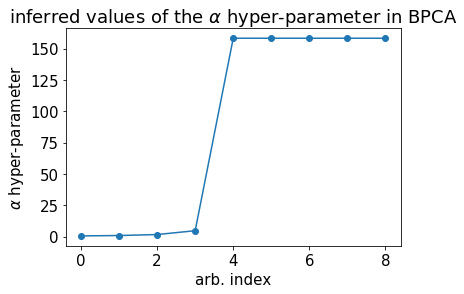

In [18]:
# distribution of alpha hyper-parameter BPCA
plt.plot(sorted(bpca.get_inv_variance()), 'o-')
plt.xlabel('arb. index')
plt.ylabel(r'$\alpha$ hyper-parameter')
plt.title(r'inferred values of the $\alpha$ hyper-parameter in BPCA')

### weight matrices

In [19]:
#helper function to visualize all weight matrices at one go
def hinton_all(bpca, ppca, pca):
    plt.subplot(1,3,1)
    plt.title('PCA weight matrix')
    hinton(pca.components_)    
    plt.subplot(1,3,2)
    plt.title('PPCA weight matrix')
    hinton(ppca._W)
    plt.subplot(1,3,3)
    plt.title('BPCA weight matrix')
    hinton(bpca.get_weight_matrix())

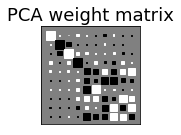

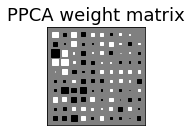

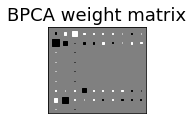

In [20]:
hinton_all(bpca, ppca, pca)

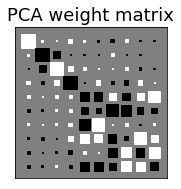

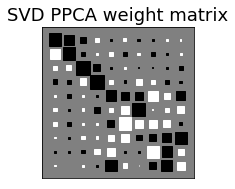

In [21]:
# SVD decomposition of PPCA weight matrix
plt.subplot(1,2,1)
plt.title('PCA weight matrix')
hinton(pca.components_)    

plt.subplot(1,2,2)
plt.title('SVD PPCA weight matrix')
hinton(np.linalg.svd(ppca._W)[0])

### covariance matrices

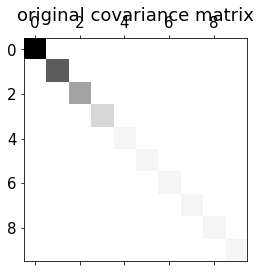

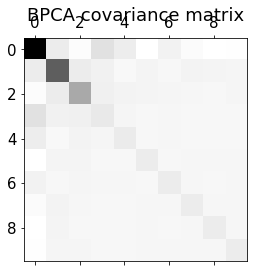

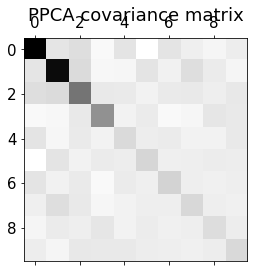

In [22]:
plt.matshow(cov, cmap=plt.cm.gray_r)
plt.title('original covariance matrix')
plt.show()
plt.matshow(bpca.get_cov_mat(), cmap=plt.cm.gray_r)
plt.title('BPCA covariance matrix')
plt.show()
plt.matshow(ppca._C, cmap=plt.cm.gray_r)
plt.title('PPCA covariance matrix')
plt.show()

### Generative Model

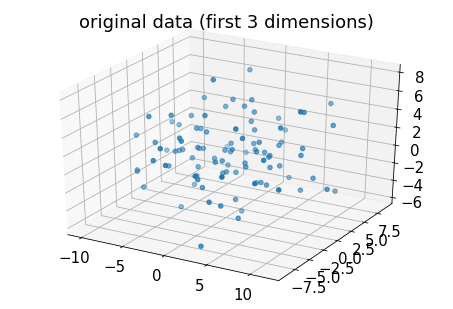

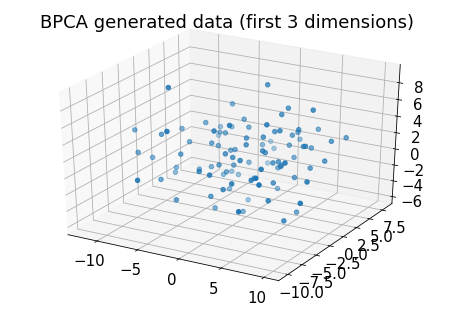

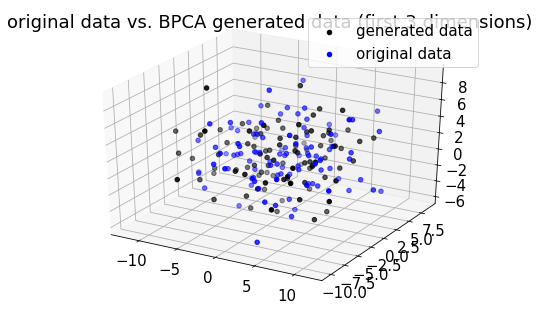

MSE in every dim: [50.06136117 25.98931153 14.8816809   4.72657398  1.79284616  1.70292519
  1.85090957  1.42413709  2.12702109  1.93801844]


In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2]);
plt.title('original data (first 3 dimensions)')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
gene = bpca.generate(100)
ax.scatter(gene[:, 0], gene[:, 1], gene[:, 2]);
plt.title('BPCA generated data (first 3 dimensions)')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(gene[:, 0], gene[:, 1], gene[:, 2], c='k', label='generated data');
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', label='original data')
plt.title('original data vs. BPCA generated data (first 3 dimensions)')
plt.legend()
plt.show()

print("MSE in every dim: " + str(np.mean((data-gene)**2, axis=0)))

# BPCA inverse variance, PPCA weight distribution vs. PCA variance ratio

In [26]:
def plot_var(bpca, ppca, pca):
    
    PPCA_w = ppca._W
    BPCA_alpha = 1/bpca.get_inv_variance()
    
    plt.plot(sorted(BPCA_alpha, reverse=True)/np.sum(BPCA_alpha), label='scaled BPCA inverse alpha')
    plt.plot(sorted(np.sum(np.abs((PPCA_w)), axis=1)/np.sum(np.sum(np.abs((PPCA_w)), axis=1)), reverse=True), label='scaled PPCA weight distribution')
    plt.plot(pca.explained_variance_ratio_, label='PCA captured variance ratio')
    plt.xlabel('number of dimentions (0 indexed)')
    plt.ylabel('captured variance')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=4, color='k', linestyle='--', alpha=0.5)
    plt.title('Captured BPCA inverse variance, PPCA weight distribution vs. PCA explained variance')
    plt.legend()
    plt.show()

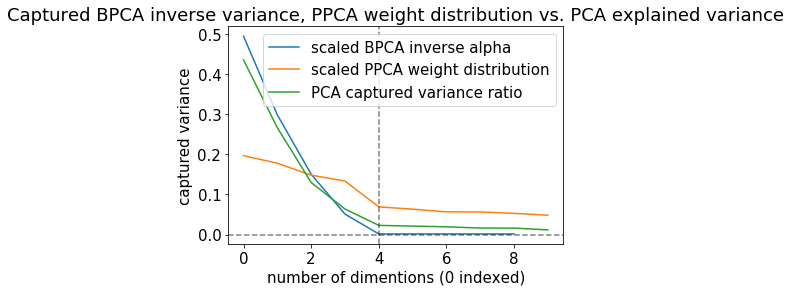

In [29]:
plot_var(bpca, ppca, pca)

# number of captured dimension

In [30]:
def captured_dimensions(bpca):
    alphas = bpca.get_inv_variance()
    inv_alphas = 1/alphas
    sum_alphas = np.sum(inv_alphas)
    num_alphas = len(alphas)
    
    return np.sum([1 for inv_alpha in inv_alphas if inv_alpha > sum_alphas/num_alphas])

In [31]:
def captured_dimensions_w(bpca):
    w_m = bpca.get_weight_matrix().T
    total_weight = np.sum(w_m, axis=1)
    
    thres = 1e-2

    return (np.sum([1 for w in total_weight if abs(w) > thres]))

In [32]:
bpca.get_inv_variance(), captured_dimensions_w(bpca), captured_dimensions(bpca)

array([  1.56889385,   0.477206  , 158.18513759, 158.18513759,
       158.18513759, 158.18513759,   4.63306975,   0.79071736,
       158.18513759])

# PPCA exhaustive search vs BPCA

C:\Users\m\Documents\Harvard\am205\BPCA\ppca.py:159: RuntimeWarning: invalid value encountered in log
  + np.trace(np.dot(pinv(self._C), self._calc_S(X, mu.reshape(-1,1)))))


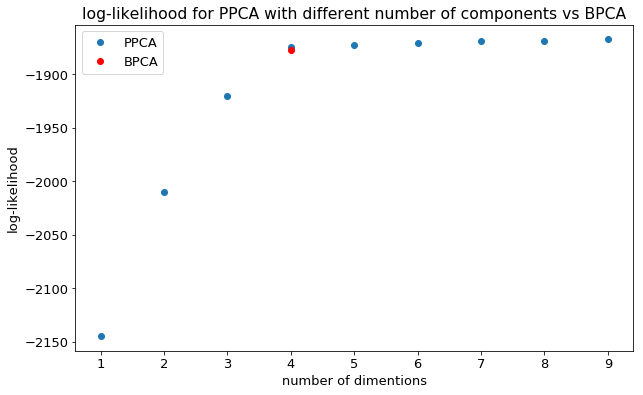

In [42]:
q_plot = []
likelihood_plot = []
#repeats = 50
repeats = 1

for q in range(1, 10):
    q_plot.append(q)
    captures = []
    for _ in range(repeats):
        plot_ppca = PPCA(n_dimension=q)
        plot_ppca.fit(data, method='EM')
        loglikes = plot_ppca.fit(data, method='EM', keep_loglikes=True)
        captures.append(loglikes[-1])
    likelihood_plot.append(np.mean(captures))      
    
captures = []
captures2 = []
for _ in range(repeats):
    bpca.fit(data, trace_loglikelihood=True)
    likelihood = bpca.get_loglikelihood()
    captures.append(likelihood[-1])
    captures2.append(captured_dimensions_w(bpca))
likelihood = np.mean(captures)
q_eff = np.mean(captures2)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 13})

plt.plot(q_plot, likelihood_plot, 'o', label='PPCA')
plt.plot(q_eff, likelihood, 'ro', label='BPCA')
plt.xlabel('number of dimentions')
plt.ylabel('log-likelihood')
plt.title('log-likelihood for PPCA with different number of components vs BPCA')
plt.legend()
plt.show()

# different number of dimensions normal distribution

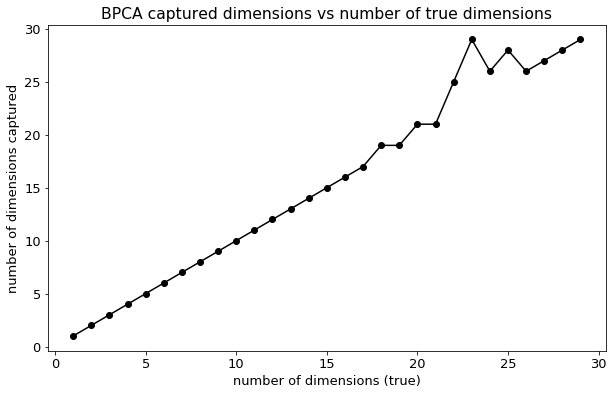

In [43]:
n_dim_plot = []
n_dim_plot_captured = []
max_dim = 30

for n_dim in np.arange(1, max_dim):
    n_dim_plot.append(n_dim)
    captures = []
    for _ in range(repeats):
        num_points = 300
        seed_arr = [i+2 for i in range(n_dim)][::-1]
        while len(seed_arr) < max_dim:
            seed_arr.extend([1])
        #print(seed_arr)

        cov = np.diag(np.array(seed_arr)**2)
        data = np.random.multivariate_normal(np.zeros(max_dim), cov, size=num_points)

        bpca = BPCA()
        bpca.fit(data, print_every=999999999)
        pca = PCA(n_components=max_dim)
        pca.fit(data)

        captures.append(captured_dimensions_w(bpca))

    n_dim_plot_captured.append(np.mean(captures))
plt.plot(n_dim_plot, n_dim_plot_captured, 'ko-')
plt.xlabel('number of dimensions (true)')
plt.ylabel('number of dimensions captured')
plt.title('BPCA captured dimensions vs number of true dimensions')
plt.show()

# different number of data points normal distribution

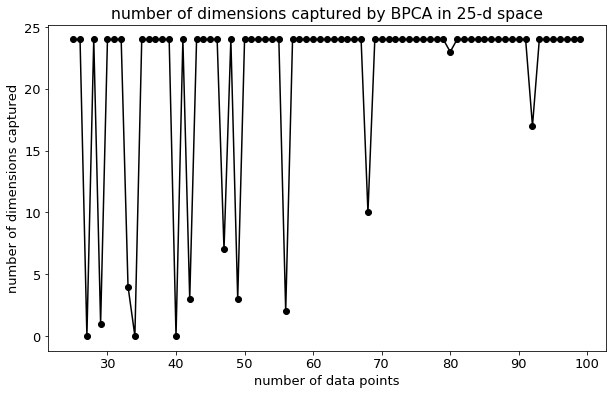

In [45]:
n_points_plot_dp = []
n_dim_plot_captured_dp = []
n_dim = 25
max_dim = n_dim

for num_points in np.arange(20, 100, 1):
    n_points_plot_dp.append(num_points)
    captures = []
    for _ in range(repeats):

        seed_arr = [i+2 for i in range(n_dim)][::-1]
        while len(seed_arr) < max_dim:
            seed_arr.extend([1])

        cov = np.diag(np.array(seed_arr)**2)
        data = np.random.multivariate_normal(np.zeros(max_dim), cov, size=num_points)

        bpca = BPCA()
        bpca.fit(data, print_every=999999999)
        pca = PCA(n_components=max_dim)
        pca.fit(data)

        captures.append(captured_dimensions_w(bpca))
    n_dim_plot_captured_dp.append(np.mean(captures))
plt.plot(n_points_plot_dp[5:], n_dim_plot_captured_dp[5:], 'ko-')
plt.xlabel('number of data points')
plt.ylabel('number of dimensions captured')
plt.title('number of dimensions captured by BPCA in 25-d space')
plt.show()

# different number of dimensions for poisson distribution

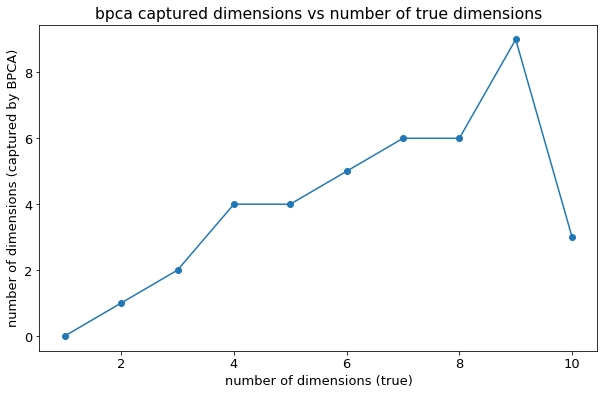

In [46]:
n_dim_plot_p = []
n_dim_plot_captured_p = []
for n_dim in np.arange(1, 11):
    n_dim_plot_p.append(n_dim)
    captures = []        
    
    for _ in range(repeats):
        max_dim = 10
        num_points = 100
        seed_arr = [i+2 for i in range(n_dim)][::-1]
        while len(seed_arr) < max_dim:
            seed_arr.extend([1])

        cov = np.diag(np.array(seed_arr)**2)
        data = None
        for seed in seed_arr:
            data_col = np.random.poisson(lam=seed, size=num_points)
            if data is None:
                data = data_col
            else:
                data = np.column_stack((data, data_col))

        bpca = BPCA()
        bpca.fit(data, print_every=999999999)
        pca = PCA(n_components=max_dim)
        pca.fit(data)

        captures.append(captured_dimensions_w(bpca))
        
    n_dim_plot_captured_p.append(np.mean(captures))
    
plt.plot(n_dim_plot_p, n_dim_plot_captured_p, 'o-')
plt.xlabel('number of dimensions (true)')
plt.ylabel('number of dimensions (captured by BPCA)')
plt.title('bpca captured dimensions vs number of true dimensions')
plt.show()

# different number of data points for poisson distribution

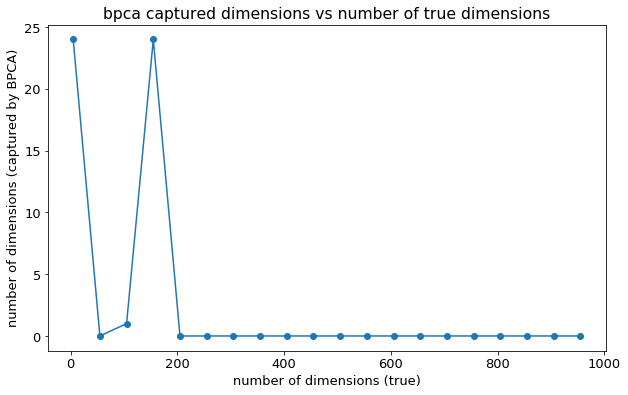

In [47]:
n_points_plot_dp_p = []
n_dim_plot_captured_dp_p = []
n_dim = 25
max_dim = n_dim

for num_points in np.arange(5, 1000, 50):
    n_points_plot_dp_p.append(num_points)
    captures = []
    for _ in range(repeats):
        seed_arr = [i+2 for i in range(n_dim)][::-1]
        while len(seed_arr) < max_dim:
            seed_arr.extend([1])
            
        cov = np.diag(np.array(seed_arr)**2)
        data = None
        for seed in seed_arr:
            data_col = np.random.poisson(lam=seed, size=num_points)
            if data is None:
                data = data_col
            else:
                data = np.column_stack((data, data_col))

        bpca = BPCA()
        bpca.fit(data, print_every=999999999)
        pca = PCA(n_components=max_dim)
        pca.fit(data)

        captures.append(captured_dimensions_w(bpca))
    n_dim_plot_captured_dp_p.append(np.mean(captures))
    
plt.plot(n_points_plot_dp_p, n_dim_plot_captured_dp_p, 'o-')
plt.xlabel('number of dimensions (true)')
plt.ylabel('number of dimensions (captured by BPCA)')
plt.title('bpca captured dimensions vs number of true dimensions')
plt.show()

# comparison of normal vs poisson

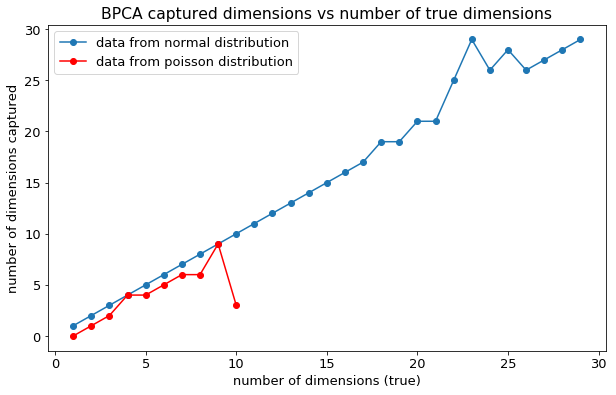

In [48]:
plt.plot(n_dim_plot, n_dim_plot_captured, 'o-', label='data from normal distribution')
plt.plot(n_dim_plot_p, n_dim_plot_captured_p, 'ro-', label='data from poisson distribution')
plt.xlabel('number of dimensions (true)')
plt.ylabel('number of dimensions captured')
plt.title('BPCA captured dimensions vs number of true dimensions')
plt.legend()
plt.show()

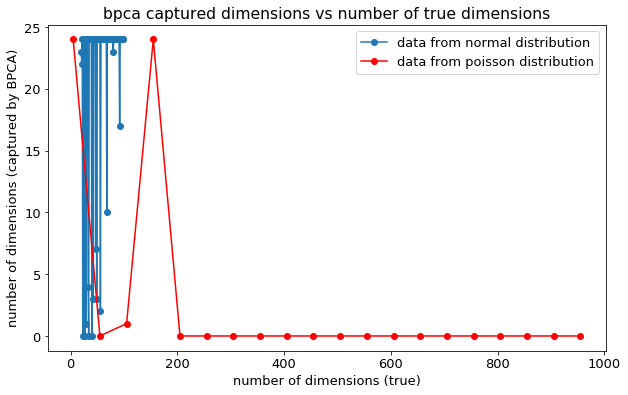

In [49]:
plt.plot(n_points_plot_dp, n_dim_plot_captured_dp, 'o-', label='data from normal distribution')
plt.plot(n_points_plot_dp_p, n_dim_plot_captured_dp_p, 'ro-', label='data from poisson distribution')
plt.xlabel('number of dimensions (true)')
plt.ylabel('number of dimensions (captured by BPCA)')
plt.title('bpca captured dimensions vs number of true dimensions')
plt.legend()
plt.show()

# MINIST



In [52]:
mnist = sklearn_data.load_digits()
Y = mnist.target
X = mnist.images
X = X.reshape(len(X),-1)
bpca = BPCA()
bpca.fit(X, iters=5000, verbose=True, print_every=1000)

Iter 0, LL: 0.000000, alpha: [  20.06995255  146.94100767   69.139972     19.36674616   76.02830688
  588.39617104  170.746077     20.72992028   29.87009137   57.77228657
   43.85015427 1676.65760791   34.96833665   31.8844002    97.74811114
   36.58209576   13.84329776  339.69310043   68.00993548   43.68960653
   76.71176136   52.02905457   84.3303636    85.53886934   45.56881016
  906.71006339   29.62721412 1578.09210364   21.37825999   20.58411109
  150.40561404   78.29820197   32.28525592   86.67165041  131.0391188
   49.68880763  236.67994102   17.88251703   43.38253466   12.26319337
   19.9933628    16.77044918   30.26866346   38.71207208   65.85914637
   29.23743432   29.36800227   25.38936383   83.63792805  291.08043631
   58.70811357   48.05644104  119.98758551   36.43283059   28.31887662
   74.50547132   43.8402391    19.18450873   14.49735798   52.36151095
   45.36860762   95.4045622    83.7281853 ]
Iter 1000, LL: 0.000000, alpha: [  16.8641842  2852.26604387    7.01436852  

In [53]:
pca = PCA(n_components=bpca.get_effective_dims())
new_X_pca = pca.inverse_transform(pca.fit_transform(X))
ppca = PPCA(n_dimension=bpca.get_effective_dims())
ppca.fit(X, method='EM')
new_X_ppca = ppca.inverse_transform(ppca.transform(X))
new_X_bpca = bpca.inverse_transform(bpca.transform())

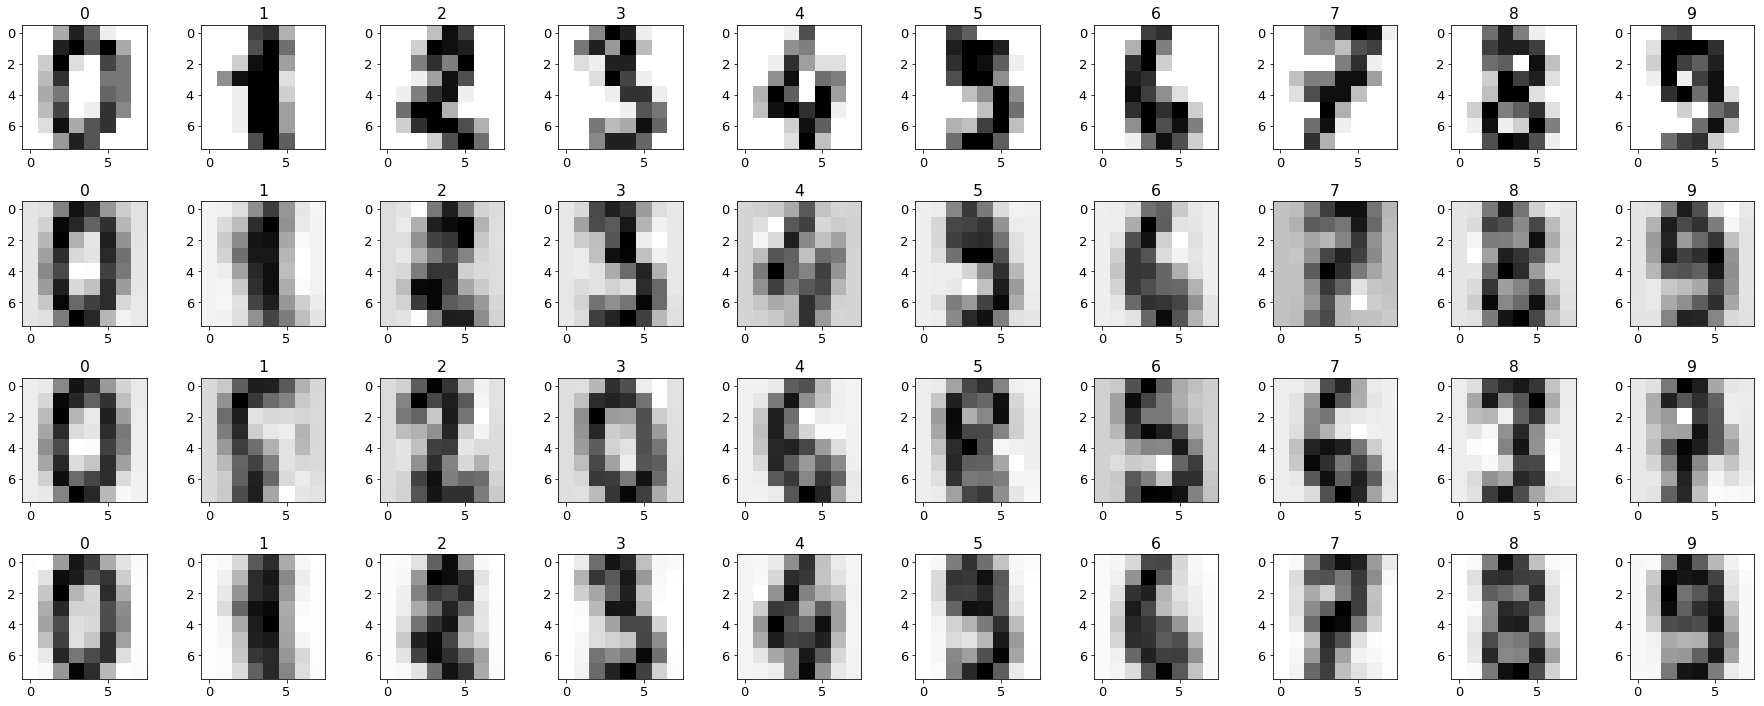

In [54]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(4,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(4,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(4,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_ppca[i*155].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(4,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')

plt.tight_layout()
plt.show()

Text(0.5,1,'distribution of inferred $\\alpha$ hyperparameter in BPCA')

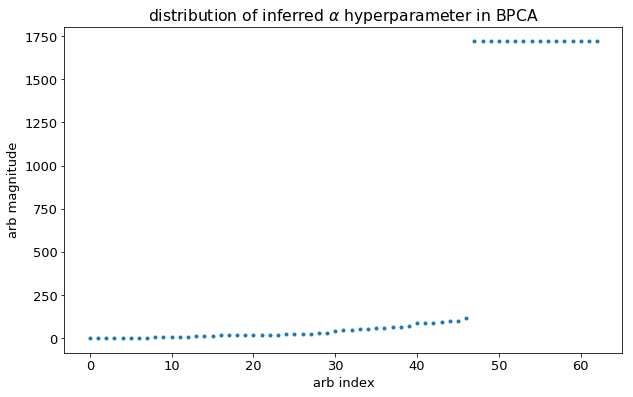

In [55]:
plt.plot(sorted(bpca.get_inv_variance()), '.')
plt.xlabel('arb index')
plt.ylabel('arb magnitude')
plt.title(r'distribution of inferred $\alpha$ hyperparameter in BPCA')

In [ ]:
q_plot = []
ll_plot = []
n_iter = 10000
n_iter = 100

# s = time.time()
for q in range(1, 65):
#     print(time.time() - s)
#     print(q)
    plot_ppca = PPCA(n_dimension=q)
    plot_ppca.fit(X, method='EM')
    loglikes = plot_ppca.fit(X, method='EM', keep_loglikes=True, n_iteration=1000)
    ll_plot.append(loglikes[-1])
    q_plot.append(q)

plt.plot(q_plot, ll_plot, 'o', label='PPCA')

C:\Users\m\Documents\Harvard\am205\BPCA\ppca.py:159: RuntimeWarning: invalid value encountered in log
  + np.trace(np.dot(pinv(self._C), self._calc_S(X, mu.reshape(-1,1)))))


In [ ]:
bpca.get_effective_dims(), captured_dimensions_w(bpca)

In [ ]:
plt.plot(bpca.get_effective_dims(), np.array(ll_all[-1])/len(X), 'ro', label='BPCA')
plt.plot(q_plot[:-12], (np.array(ll_plot)/len(X))[:-12], 'o', label='PPCA')
plt.xlabel('number of dimentions')
plt.ylabel('log-likelihood')
plt.legend()
plt.title('log-likelihood for PPCA with different number of components vs BPCA (MNIST)')
plt.show()